In [1]:
import sys

sys.path.append('.')

import model

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
import statistics

# 2D Lattice with rewiring

We start with an $m \times n$ periodic square lattice.

In [3]:
N, M = (45, 45)

g = nx.grid_2d_graph(N, M, periodic=True, create_using=None)

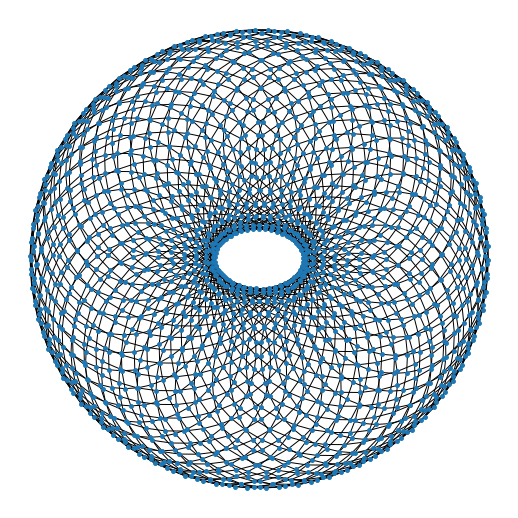

In [4]:
plt.figure(3,figsize=(7,7)) 
## draw_spectral for the lattice
foo = nx.draw_spectral(g,
                node_size = 15)

In [5]:
dummy_g = nx.grid_2d_graph(
        N,
        M,
        periodic=True,
        create_using=None
    )
torus_pos = nx.spectral_layout(dummy_g)

Then for each edge $(u,v)$, with probability $p$, we replace that edge with a new edge $(u,w)$, where $w$ is randomly sampled from the existing nodes.

In [6]:
g = model.grid_r(N,M, 0.1)

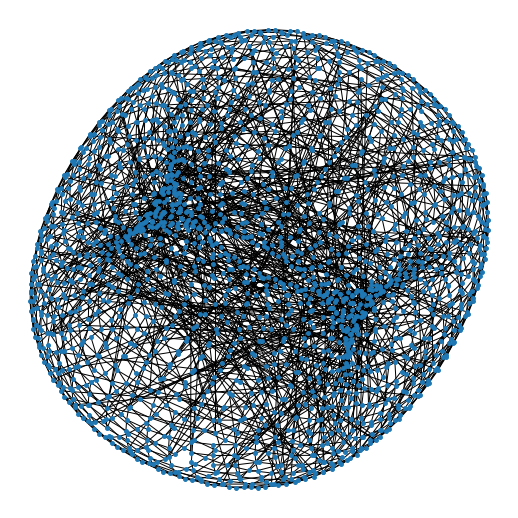

In [7]:
plt.figure(3,figsize=(7,7)) 
## draw_spectral for the lattice
nx.draw(g,
        pos = torus_pos,
        node_size = 15)

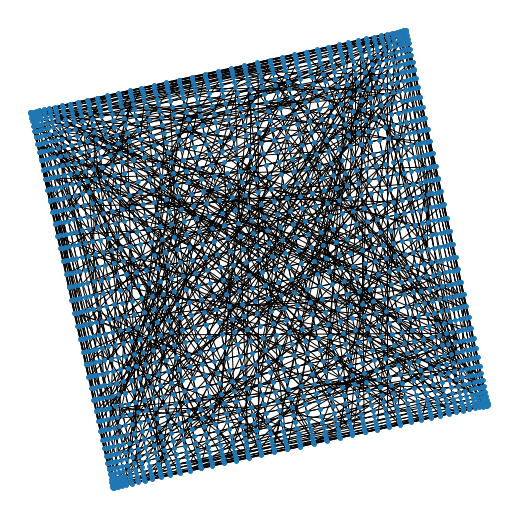

In [8]:
plt.figure(3,figsize=(7,7)) 
## draw_spectral for the lattice
nx.draw(g,
        pos = model.grid_pos(g),
        node_size = 15)

In [9]:
len(g.edges)

4049

# Looking at infection on the 2D lattice, no contact tracing

We will keep $n = 45$, $m = 45$, which keeps the total number of nodes comparable to the earlier Watts-Strogatz based study.

What is the effect of rewiring rate $p$ on infection, without tracing?

In [10]:
## Population parameters:
base_params = {
    # Node parameter
    'A' : 0.5, 
    
    # Edge parameter
    'W' : .5, # probability of edge activation; 2/K
    'C' : 1.0,
    
    ## Disease parameters

    'beta_hat' : .4, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

In [11]:
## Illustrative single simulation

In [12]:
g_live = model.initialize_graph(g, base_params)

t = 0
#g_live = g.copy()
#initialize(g_live,params)
history = {}

s_count = []

while len(model.get_infected(g_live)) > 0 and t < float("inf"):
    if t != 0 and t % len(g_live.nodes()) / 100 == 0:
        print("Trial %d hits time step %d" % (i,t))

    s_count.append(len(model.susceptible(g_live)))

    g_live, history = model.loop(base_params, g_live, history, t)

    t = t + 1

In [13]:
print(model.green_cmap(0))
print(model.green_cmap(t))

(0.9686274509803922, 0.9882352941176471, 0.9607843137254902, 1.0)
(0.9287658592848904, 0.9727335640138408, 0.9142791234140715, 1.0)


In [14]:
list(g_live.edges(data=True))[20]

((0, 5), (0, 6), {'w': 0.5, 'c': 1.0})

In [15]:
#[int(model.edge_adopter(g_live,e)) for e in g_live.edges(data=True)]

In [16]:
list(g_live.edges(data=True))[20][2]['c'] * int(model.edge_adopter(g_live, list(g_live.edges(data=True))[20]))

0.0

/home/sb/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


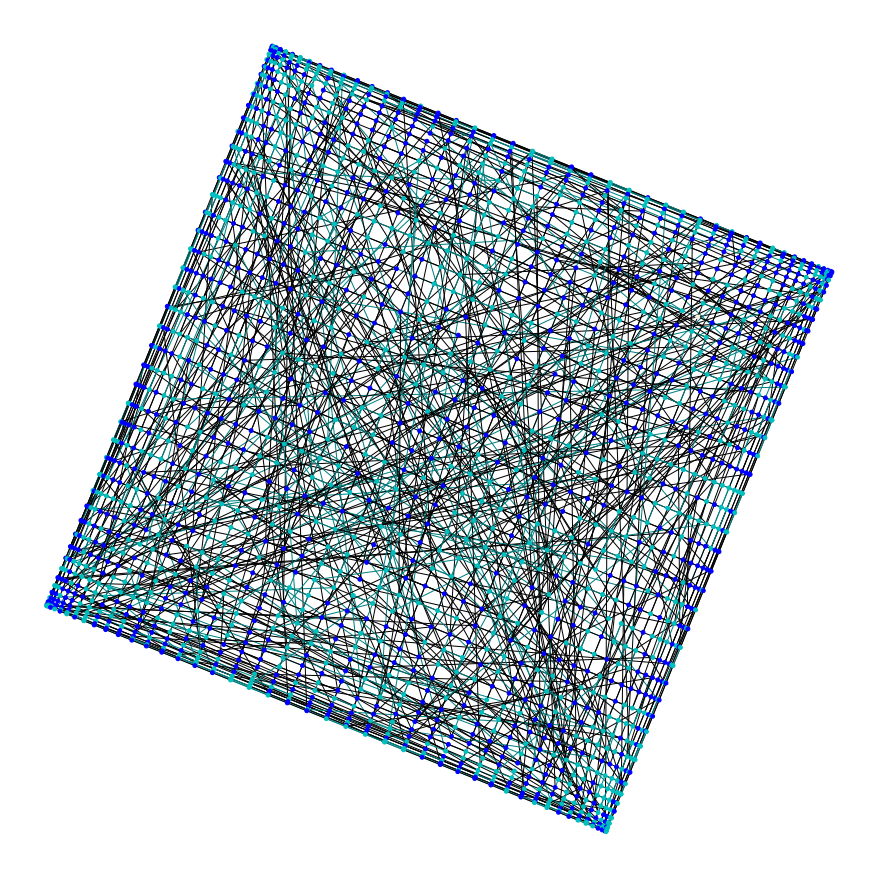

In [17]:
plt.figure(3,figsize=(12,12)) 
## draw_spectral for the lattice
nx.draw(g_live,
        pos = model.grid_pos(g_live),
        node_color = model.node_colors(g_live),
        edge_color = model.edge_colors(g_live),
        node_size = 15)

In [18]:
g_live.nodes[(0,0)]

{'adopter': False,
 'group': 0,
 'quarantined': False,
 'symptomatic': False,
 'tested': False,
 'epi-state': 'Susceptible'}

## Larger scale simulation

In [19]:
base_params['A'] = 0.0
base_params['C'] = 0.0

In [20]:
def square_lattice_rewiring_case(N, M, p, **kwargs):

    g = nx.grid_2d_graph(N, M, periodic=True)

    for e in g.edges:
        if random.random() <= p:
            g.remove_edge(e[0],e[1])
            v = random.choice(list(g.nodes()))
            g.add_edge(e[0], v)

    g.graph['N'] = N
    g.graph['M'] = M
    g.graph['p'] = p

    return g, kwargs


def square_r_case_generator(N, M, **kwargs):
    def sqrg(**kwargs):
        return square_lattice_rewiring_case(N, M, **kwargs)
    
    return sqrg

In [21]:
conditions = {
    'p-0.000' : {'p' : 0.000},
    'p-0.005' : {'p' : 0.005},
    'p-0.010' : {'p' : 0.010},
    'p-0.025' : {'p' : 0.025},
    'p-0.050' : {'p' : 0.050},
    'p-0.075' : {'p' : 0.075},
    'p-0.100' : {'p' : 0.100},
    'p-0.250' : {'p' : 0.250},
    'p-0.500' : {'p' : 0.500},
    'p-0.750' : {'p' : 0.750},
    'p-1.000' : {'p' : 1.00},
}

In [22]:
def dfr(rs):
    return pd.DataFrame(
        [r for case in rs 
         for r in model.data_from_results(rs, case)])

In [23]:
#runs = 100

#N, M = (45, 45)

#results = model.experiment(
#    square_r_case_generator(N, M),
#    base_params,
#    conditions,
#    runs
#)
#
#temp = dfr(results)
#temp.to_csv('p_square_study.csv')

In [24]:
#temp = dfr(results)
#temp.to_csv('p_square_study.csv')
temp = pd.read_csv('p_square_study.csv')

In [25]:
temp.columns

Index(['Unnamed: 0', 'time', 'A', 'W', 'C', 'beta_hat', 'alpha', 'gamma',
       'zeta', 'limit', 'N', 'M', 'p', 's_final', 'route_adjacent_ratio',
       'traced_edges', 'traced_edges_distant', 'group 0 adoption rate',
       'group 1 adoption rate', 'avg. exp. interval - group 0',
       'avg. exp. interval - group 1', 'avg. eff. inf. interval - group 0',
       'avg. eff. inf. interval - group 1', 'case', 'infected_ratio'],
      dtype='object')

**Infected ratio** needs to be reset because we calculate it originally using a different sense of _N_.

In [26]:
temp['nodes'] = temp['N'] * temp['M']
temp['infected_ratio'] = (temp['nodes'] - temp['s_final']) / temp['nodes']

[Text(0.5, 1.0, '2D Lattice Rewiring and Infectiousness'),
 Text(0.5, 0, 'rewiring rate'),
 Text(0, 0.5, 'infected ratio')]

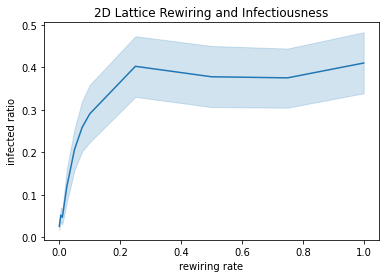

In [27]:
splot = sns.lineplot(x='p', y='infected_ratio', data=temp)
splot.set(title='2D Lattice Rewiring and Infectiousness', xlabel='rewiring rate', ylabel='infected ratio')

In [28]:
## Population parameters:
base_params_A = {
    
    'p' : 0.1, ## picking a p-star
    
    # Node parameter
    'A' : 0.0, # This will vary by condition
    
    # Edge parameter
    'W' : .5, # probability of edge activation; 2/K
    'C' : 1.0, ## no edges can be traced.
    
    ## Disease parameters

    'beta_hat' : .4, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

In [29]:
conditions_A = {
    'A-0.000' : {'A' : 0.000},
    'A-0.005' : {'A' : 0.005},
    'A-0.007' : {'A' : 0.007},
    'A-0.010' : {'A' : 0.010},
    'A-0.025' : {'A' : 0.025},
    'A-0.050' : {'A' : 0.050},
    'A-0.075' : {'A' : 0.075},
    'A-0.100' : {'A' : 0.100},
    'A-0.200' : {'A' : 0.200},
    'A-0.30' : {'A' : 0.30},
    'A-0.500' : {'A' : 0.500},
    'A-0.750' : {'A' : 0.750},
    'A-1.000' : {'A' : 1.00},
}

In [30]:
#runs = 200

#N, M = (45, 45)

#results = model.experiment(
#    square_r_case_generator(N, M),
#    base_params_A,
#    conditions_A,
#    runs
#)

#temp_A = dfr(results)
#temp_A.to_csv('A_square_study.csv')

In [31]:
temp = pd.read_csv('A_square_study.csv')

temp['nodes'] = temp['N'] * temp['M']
temp['infected_ratio'] = (temp['nodes'] - temp['s_final']) / temp['nodes']

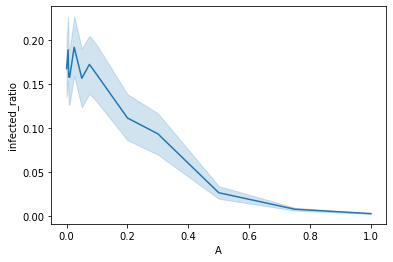

In [32]:
splot = sns.lineplot(x='A', y='infected_ratio', data=temp)

$\Sigma x^2$

In [33]:
## Population parameters:
base_params_QR = {
    # will this work?
    'p' : 0.1,
    
    # Node parameter
    'A' : 1.0, # 
    
    # Edge parameter
    'W' : .5, # probability of edge activation; 2/K
    'C' : 1.0, ## all edges can be traced.
    
    ## Disease parameters

    'beta_hat' : .4, # probability of transmission upon contact
    'alpha' : .25, # probability of exposed becoming infectious
    'gamma' : .1, # probability of infectious becoming recovered
    'zeta' : .1, # probability of infectious becoming symptomatic

    ## Contact tracing parameters

    'limit' : 10, # number of time steps the contact tracing system remembers
}

In [34]:
conditions_QR = {}

q_range = np.arange(0, 1, 0.1)
r_range = np.arange(0, 1, 0.05)

for q in q_range:
    for r in r_range:
        conditions_QR[f'q-{q}_r-{r}'] = {
            'C' : model.qr_knockout_lattice(q, r),
            'q' : q,
            'r' : r
        }
        
print(len(conditions_QR))

200


$T \sim (pq + (1-p)r)N$

In [35]:
conditions_QR

{'q-0.0_r-0.0': {'C': <function model.qr_knockout_lattice.<locals>.knockout(g, e)>,
  'q': 0.0,
  'r': 0.0},
 'q-0.0_r-0.05': {'C': <function model.qr_knockout_lattice.<locals>.knockout(g, e)>,
  'q': 0.0,
  'r': 0.05},
 'q-0.0_r-0.1': {'C': <function model.qr_knockout_lattice.<locals>.knockout(g, e)>,
  'q': 0.0,
  'r': 0.1},
 'q-0.0_r-0.15000000000000002': {'C': <function model.qr_knockout_lattice.<locals>.knockout(g, e)>,
  'q': 0.0,
  'r': 0.15000000000000002},
 'q-0.0_r-0.2': {'C': <function model.qr_knockout_lattice.<locals>.knockout(g, e)>,
  'q': 0.0,
  'r': 0.2},
 'q-0.0_r-0.25': {'C': <function model.qr_knockout_lattice.<locals>.knockout(g, e)>,
  'q': 0.0,
  'r': 0.25},
 'q-0.0_r-0.30000000000000004': {'C': <function model.qr_knockout_lattice.<locals>.knockout(g, e)>,
  'q': 0.0,
  'r': 0.30000000000000004},
 'q-0.0_r-0.35000000000000003': {'C': <function model.qr_knockout_lattice.<locals>.knockout(g, e)>,
  'q': 0.0,
  'r': 0.35000000000000003},
 'q-0.0_r-0.4': {'C': <funct

In [36]:
runs = 100

N, M = (45, 45)

#results = model.experiment(
#    square_r_case_generator(N, M),
#    base_params_QR,
#    conditions_QR,
#    runs
#)

#temp_QR = dfr(results)
#temp_QR.to_csv('QR_square_study_2.csv')

In [37]:
#data1 = pd.read_csv('QR_square_study.csv')
#data2 = pd.read_csv('QR_square_study_2.csv')

#data3 = pd.concat([data1, data2])
#data3.to_csv('QR_square_study_3.csv')

In [38]:
data = pd.read_csv('QR_square_study_3.csv')

data['traced_edges_close'] = data['traced_edges'] - data['traced_edges_distant']
data['traced_edges_ratio'] = data['traced_edges'] / (data['N'] * data['M'] * 2)
data['traced_edges_close_ratio'] = (data['traced_edges_close'] + 1) / (data['traced_edges'] + 1)

data['traced_edges+'] = data['traced_edges'] + 1
data['traced_edges_distant_ratio+'] = (data['traced_edges_distant'] + 1) / (data['traced_edges'] + 1)

data['D'] = (data['p'] * data['q']) / ((1 - data['p']) * data['r'] + data['p'] * data['q'])
data['T'] = ((1 - data['p']) * data['r'] + data['p'] * data['q'])

data['nodes'] = data['N'] * data['M']
data['infected_ratio'] = (data['nodes'] - data['s_final']) / data['nodes']

In [39]:
data['N'] * data['M'] * 2 * data['p']

0        405.0
1        405.0
2        405.0
3        405.0
4        405.0
         ...  
39995    405.0
39996    405.0
39997    405.0
39998    405.0
39999    405.0
Length: 40000, dtype: float64

In [40]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'time', 'A', 'W', 'C', 'beta_hat',
       'alpha', 'gamma', 'zeta', 'limit', 'q', 'r', 'N', 'M', 'p', 's_final',
       'route_adjacent_ratio', 'traced_edges', 'traced_edges_distant',
       'group 0 adoption rate', 'group 1 adoption rate',
       'avg. exp. interval - group 0', 'avg. exp. interval - group 1',
       'avg. eff. inf. interval - group 0',
       'avg. eff. inf. interval - group 1', 'case', 'infected_ratio',
       'traced_edges_close', 'traced_edges_ratio', 'traced_edges_close_ratio',
       'traced_edges+', 'traced_edges_distant_ratio+', 'D', 'T', 'nodes'],
      dtype='object')

In [41]:
data[['traced_edges', 'traced_edges_distant']]

traced_edges  traced_edges_distant
0                 0                     0
1                 0                     0
2                 0                     0
3                 0                     0
4                 0                     0
...             ...                   ...
39995          3834                   445
39996          3821                   437
39997          3833                   435
39998          3826                   433
39999          3829                   436

[40000 rows x 2 columns]

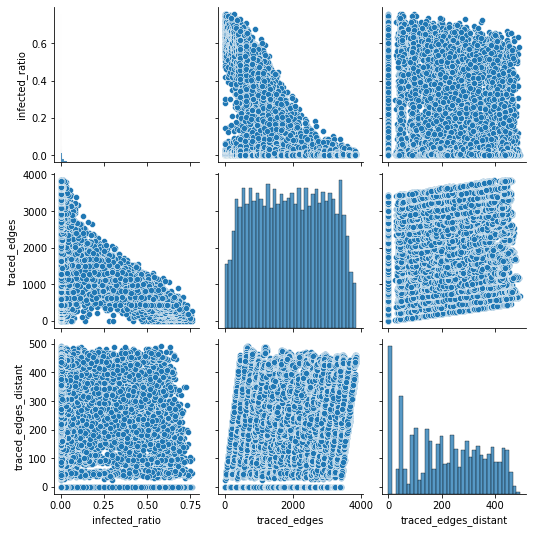

In [42]:
sns.pairplot(
    data[[
        'infected_ratio',
        'traced_edges',
        #'traced_edges_close',
        'traced_edges_distant'
    ]
    ])

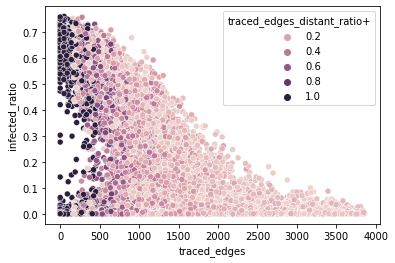

In [43]:
g = sns.scatterplot(
    data = data.sample(frac=1),
    y = 'infected_ratio',
    x = 'traced_edges',
    hue = 'traced_edges_distant_ratio+'
)

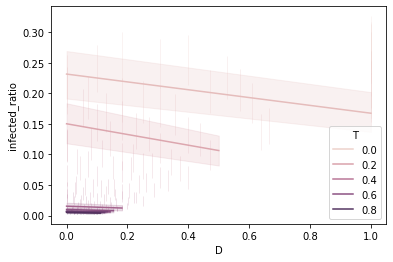

In [44]:
g = sns.lineplot(
    data = data.sample(frac=1),
    y = 'infected_ratio',
    x = 'D',
    hue = 'T'
)

In [45]:
data[['infected_ratio', 'T', 'D', 'traced_edges', 'traced_edges_distant_ratio+']].corr(
    method='pearson'
).dropna(how='all').dropna(axis=1,how='all')['infected_ratio']

infected_ratio                 1.000000
T                             -0.421225
D                              0.336231
traced_edges                  -0.422323
traced_edges_distant_ratio+    0.349167
Name: infected_ratio, dtype: float64

In [46]:
data[['infected_ratio', 'q', 'r', 'T', 'D', 'traced_edges', 'traced_edges_distant_ratio+']].corr(
    method='spearman'
).dropna(how='all').dropna(axis=1,how='all')['infected_ratio']

infected_ratio                 1.000000
q                             -0.035265
r                             -0.212362
T                             -0.214867
D                              0.114967
traced_edges                  -0.215244
traced_edges_distant_ratio+    0.120398
Name: infected_ratio, dtype: float64

In [47]:
import pingouin as pg
pg.partial_corr(
    data=data,
    x='traced_edges_close',
    y='infected_ratio',
    covar='traced_edges_distant',
    method='spearman'
)

/home/sb/anaconda3/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


n         r           CI95%  p-val
spearman  40000 -0.259543  [-0.27, -0.25]    0.0

In [48]:
import pingouin as pg
pg.partial_corr(
    data=data,
    x='traced_edges_close',
    y='infected_ratio',
    method='spearman'
)

n         r          CI95%  p-val
spearman  40000 -0.212307  [-0.22, -0.2]    0.0

In [49]:
pg.partial_corr(data=data, x='traced_edges', y='infected_ratio')

n         r           CI95%  p-val
pearson  40000 -0.422323  [-0.43, -0.41]    0.0

In [50]:
data[['traced_edges', 'traced_edges_distant']][data['traced_edges'] < 500]

traced_edges  traced_edges_distant
0                 0                     0
1                 0                     0
2                 0                     0
3                 0                     0
4                 0                     0
...             ...                   ...
38095           440                   440
38096           442                   442
38097           454                   454
38098           447                   447
38099           443                   443

[4110 rows x 2 columns]

[Text(0.5, 1.0, 'Infected ratio with variable tracing'),
 Text(0.5, 15.0, 'traced edges'),
 Text(33.0, 0.5, 'traced edges: close')]

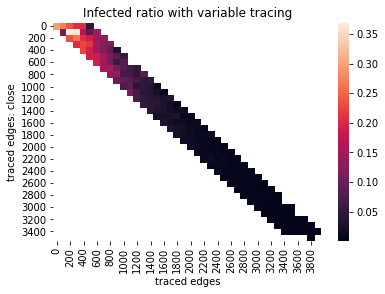

In [51]:
base = 100

g, xyz, db = model.binned_heatmap(
    data,
    x = 'traced_edges',
    x_base = base,
    y = 'traced_edges_close',
    y_base = base,
    z = 'infected_ratio'
)

g.set(#xscale="log",
      title='Infected ratio with variable tracing',
      xlabel='traced edges',
      ylabel='traced edges: close')

In [52]:
#sns.lineplot(
#    x='x_bin',
#    y='infected_ratio',
#    hue='y_bin',
#    data=wxyz
#)

[Text(0.5, 1.0, 'Infected ratio with variable tracing'),
 Text(0.5, 15.0, 'traced edges: distant'),
 Text(33.0, 0.5, 'traced edges: close')]

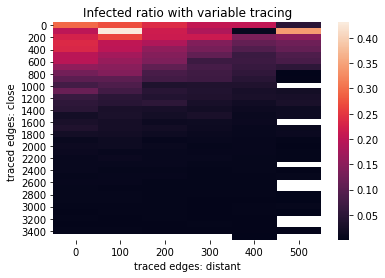

In [53]:
base = 100

g, xyz, db = model.binned_heatmap(
    data,
    x = 'traced_edges_distant',
    x_base = base,
    y = 'traced_edges_close',
    y_base = base,
    z = 'infected_ratio'
)

g.set(#xscale="log",
      title='Infected ratio with variable tracing',
      xlabel='traced edges: distant',
      ylabel='traced edges: close')

In [54]:
xyz.shape

(36, 6)

In [55]:
list(xyz.columns)

[0, 100, 200, 300, 400, 500]

In [56]:
wxyz = pd.melt(
    xyz.reset_index(),
    id_vars="y_bin",
    value_vars=list(xyz.columns),
    value_name="infected_ratio"
)

wxyz

y_bin x_bin  infected_ratio
0        0     0        0.296079
1      100     0        0.199295
2      200     0        0.226662
3      300     0        0.236166
4      400     0        0.233010
..     ...   ...             ...
211   3100   500        0.001975
212   3200   500             NaN
213   3300   500             NaN
214   3400   500        0.003673
215   3500   500             NaN

[216 rows x 3 columns]

<AxesSubplot:xlabel='y_bin', ylabel='infected_ratio'>

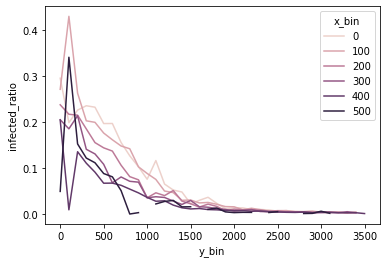

In [57]:
sns.lineplot(
    x='y_bin',
    y='infected_ratio',
    hue='x_bin',
    data=wxyz
)

Text(0.5, 0, 'Traced edges')

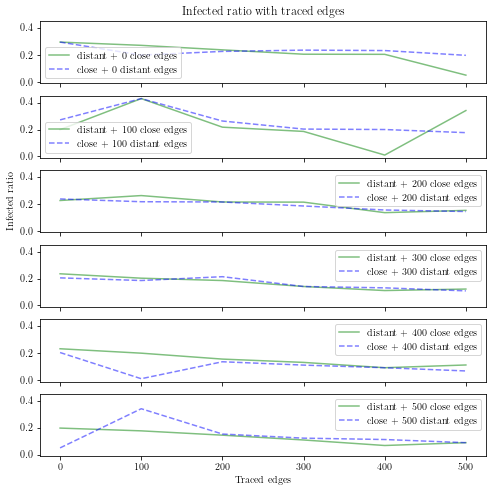

In [58]:
num_plots = 6

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

fig, ax = plt.subplots(
    num_plots, 1,
    sharex='col',
    sharey='col',
    figsize=(8,8),
)

x_range = list(range(0, xyz.shape[1] * base, base))

for i in range(num_plots):
    ax[i].plot(
        x_range,
        xyz.values[i,:],
        'g',
        alpha=0.5,
        label=f"distant + {i * base} close edges"
    )
    
for i in range(num_plots):
    ax[i].plot(
        x_range,
        xyz.values[:len(x_range),i],
        "b--",
        alpha=0.5,
        label=f"close + {i * base} distant edges"
    )
    ax[i].legend()
    
ax[0].set_title("Infected ratio with traced edges")
ax[2].set_ylabel("Infected ratio")
ax[5].set_xlabel("Traced edges")

 Trying to separate out the modes.

In [59]:
data['infected_ratio'].mode()

0    0.000494
dtype: float64

(array([34923.,   765.,   448.,   395.,   448.,   582.,   787.,   828.,
          660.,   164.]),
 array([4.93827160e-04, 7.64938272e-02, 1.52493827e-01, 2.28493827e-01,
        3.04493827e-01, 3.80493827e-01, 4.56493827e-01, 5.32493827e-01,
        6.08493827e-01, 6.84493827e-01, 7.60493827e-01]),
 <BarContainer object of 10 artists>)

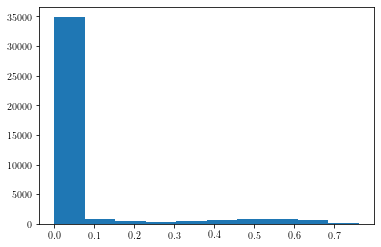

In [60]:
plt.hist(data['infected_ratio'])

In [61]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'time', 'A', 'W', 'C', 'beta_hat',
       'alpha', 'gamma', 'zeta', 'limit', 'q', 'r', 'N', 'M', 'p', 's_final',
       'route_adjacent_ratio', 'traced_edges', 'traced_edges_distant',
       'group 0 adoption rate', 'group 1 adoption rate',
       'avg. exp. interval - group 0', 'avg. exp. interval - group 1',
       'avg. eff. inf. interval - group 0',
       'avg. eff. inf. interval - group 1', 'case', 'infected_ratio',
       'traced_edges_close', 'traced_edges_ratio', 'traced_edges_close_ratio',
       'traced_edges+', 'traced_edges_distant_ratio+', 'D', 'T', 'nodes'],
      dtype='object')

In [191]:
data['time']

0         55
1        333
2         56
3        347
4         15
        ... 
39995     33
39996     46
39997      1
39998     28
39999     25
Name: time, Length: 40000, dtype: int64

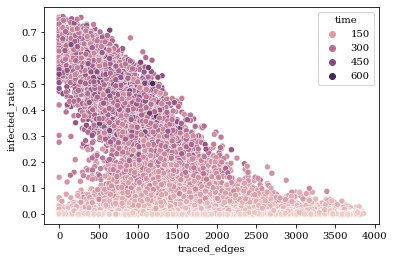

In [194]:
g = sns.scatterplot(
    data = data.sample(frac=1),
    y = 'infected_ratio',
    x = 'traced_edges',
    hue = 'time'
)

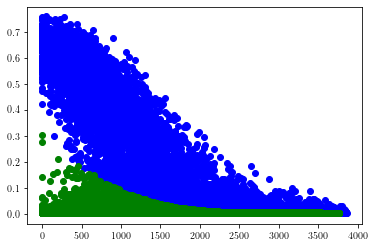

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)

X = data['traced_edges'].values.reshape(-1, 1)  # values converts it into a numpy array
X2 = poly.fit_transform(X)
Y = data['infected_ratio'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X2, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X2)  # make predictions



data['upper_mode'] = pd.Series((Y > Y_pred).reshape(-1))

data_upper = data[data['upper_mode']]
data_lower = data[~data['upper_mode']]

X_upper = data_upper['traced_edges'].values.reshape(-1, 1)  # values converts it into a numpy array
X_upper2 = poly.fit_transform(X_upper)

Y_upper = data_upper['infected_ratio'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linreg_upper = LinearRegression()  # create object for the class
linreg_upper.fit(X_upper2, Y_upper)  # perform linear regression
Y_upper_pred = linreg_upper.predict(X_upper2)  # make predictions


X_lower = data_lower['traced_edges'].values.reshape(-1, 1)  # values converts it into a numpy array
Y_lower = data_lower['infected_ratio'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linreg_lower = LinearRegression()  # create object for the class
linreg_lower.fit(X_lower, Y_lower)  # perform linear regression
Y_lower_pred = linreg_lower.predict(X_lower)  # make predictions

d = data[data['upper_mode']]
plt.scatter(d['traced_edges'], d['infected_ratio'], color = 'blue')
    
d = data[~data['upper_mode']]
plt.scatter(d['traced_edges'], d['infected_ratio'], color = 'green')

plt.plot(X, Y_pred,linestyle='None',color='red')
#plt.plot(X_upper, Y_upper_pred, color='yellow')
#plt.plot(X_lower, Y_lower_pred, color='cyan')
plt.show()


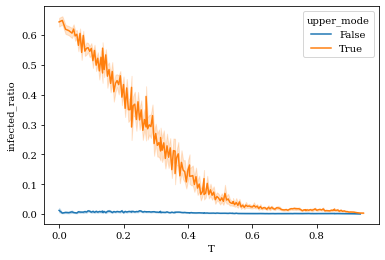

In [64]:
plt.rc('text', usetex=False)
g = sns.lineplot(
    data = data.fillna(0),
    y = 'infected_ratio',
    x = 'T',
    hue='upper_mode'
)

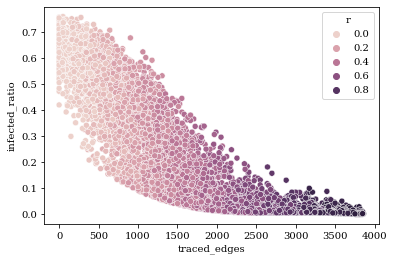

In [83]:
g = sns.scatterplot(
    data = data[data['upper_mode']].sample(frac=1),
    y = 'infected_ratio',
    x = 'traced_edges',
    hue = 'r'
)

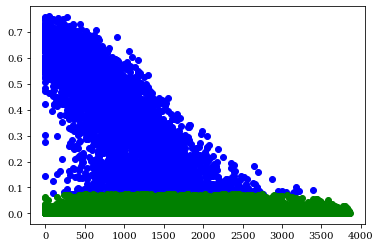

In [198]:
data['upper_mode'] = data['infected_ratio'] > 0.075

data_upper = data[data['upper_mode']]
data_lower = data[~data['upper_mode']]


d = data[data['upper_mode']]
plt.scatter(d['traced_edges'], d['infected_ratio'], color = 'blue')
    
d = data[~data['upper_mode']]
plt.scatter(d['traced_edges'], d['infected_ratio'], color = 'green')

plt.plot(X, Y_pred,linestyle='None',color='red')
#plt.plot(X_upper, Y_upper_pred, color='yellow')
#plt.plot(X_lower, Y_lower_pred, color='cyan')
plt.show()

In [199]:
50/2050

0.024390243902439025

In [200]:
data

Unnamed: 0  Unnamed: 0.1  time    A    W   C  beta_hat  alpha  gamma  \
0               0             0    55  1.0  0.5 NaN       0.4   0.25    0.1   
1               1             1   333  1.0  0.5 NaN       0.4   0.25    0.1   
2               2             2    56  1.0  0.5 NaN       0.4   0.25    0.1   
3               3             3   347  1.0  0.5 NaN       0.4   0.25    0.1   
4               4             4    15  1.0  0.5 NaN       0.4   0.25    0.1   
...           ...           ...   ...  ...  ...  ..       ...    ...    ...   
39995       19995         19995    33  1.0  0.5 NaN       0.4   0.25    0.1   
39996       19996         19996    46  1.0  0.5 NaN       0.4   0.25    0.1   
39997       19997         19997     1  1.0  0.5 NaN       0.4   0.25    0.1   
39998       19998         19998    28  1.0  0.5 NaN       0.4   0.25    0.1   
39999       19999         19999    25  1.0  0.5 NaN       0.4   0.25    0.1   

       zeta  ...  traced_edges_close_ratio  traced_edges+  \
0       0.1  ...                  1.000000              1   
1       0.1  ...                  1.000000              1   
2       0.1  ...                  1.000000              1   
3       0.1  ...                  1.000000              1   
4       0.1  ...                  1.000000              1   
...     ...  ...                       ...            ...   
39995   0.1  ...                  0.883963           3835   
39996   0.1  ...                  0.885662           3822   
39997   0.1  ...                  0.886541           3834   
39998   0.1  ...                  0.886857           3827   
39999   0.1  ...                  0.886162           3830   

       traced_edges_distant_ratio+         D      T  nodes  upper_mode  gmode  \
0                         1.000000       NaN  0.000   2025       False      1   
1                         1.000000       NaN  0.000   2025        True      1   
2                         1.000000       NaN  0.000   2025       False      1   
3                         1.000000       NaN  0.000   2025        True      1   
4                         1.000000       NaN  0.000   2025       False      1   
...                            ...       ...    ...    ...         ...    ...   
39995                     0.116297  0.095238  0.945   2025       False      1   
39996                     0.114600  0.095238  0.945   2025       False      1   
39997                     0.113719  0.095238  0.945   2025       False      1   
39998                     0.113405  0.095238  0.945   2025       False      1   
39999                     0.114099  0.095238  0.945   2025       False      1   

       gmode_0_mean  gmode_1_mean  
0          0.630870      0.005682  
1          0.630870      0.005682  
2          0.630870      0.005682  
3          0.630870      0.005682  
4          0.630870      0.005682  
...             ...           ...  
39995      0.002129      0.009594  
39996      0.002129      0.009594  
39997      0.002129      0.009594  
39998      0.002129      0.009594  
39999      0.002129      0.009594  

[40000 rows x 40 columns]

In [201]:
pd.Series((Y > Y_pred).reshape(-1))

0        False
1         True
2        False
3         True
4        False
         ...  
39995     True
39996     True
39997     True
39998     True
39999     True
Length: 40000, dtype: bool

In [202]:
data.groupby(['traced_edges'])['infected_ratio'].mean()

traced_edges
0       0.302751
23      0.003457
30      0.359012
31      0.001481
33      0.388313
          ...   
3848    0.004938
3849    0.002222
3851    0.005432
3854    0.004938
3859    0.002469
Name: infected_ratio, Length: 3798, dtype: float64

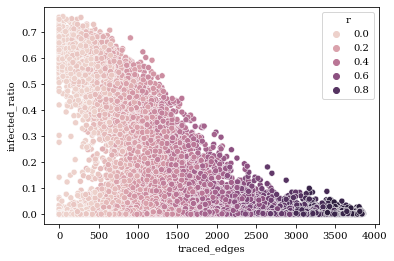

In [203]:
g = sns.scatterplot(
    data = data.sample(frac=1),
    y = 'infected_ratio',
    x = 'traced_edges',
    hue = 'r'
)

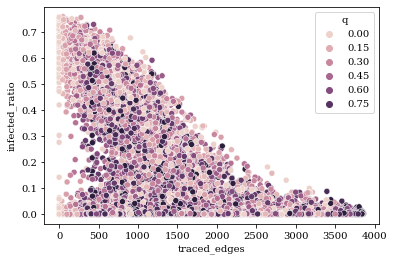

In [204]:
g = sns.scatterplot(
    data = data.sample(frac=1),
    y = 'infected_ratio',
    x = 'traced_edges',
    hue = 'q'
)

In [234]:
data[data['T'] == 0.3]

Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 0.1, time, A, W, C, beta_hat, alpha, gamma, zeta, limit, q, r, N, M, p, s_final, route_adjacent_ratio, traced_edges, traced_edges_distant, group 0 adoption rate, group 1 adoption rate, avg. exp. interval - group 0, avg. exp. interval - group 1, avg. eff. inf. interval - group 0, avg. eff. inf. interval - group 1, case, infected_ratio, traced_edges_close, traced_edges_ratio, traced_edges_close_ratio, traced_edges+, traced_edges_distant_ratio+, D, T, nodes, upper_mode, gmode, gmode_0_mean, gmode_1_mean]
Index: []

[0 rows x 40 columns]

In [233]:
import pingouin as pg
pg.partial_corr(
    data=data[data['T'] == 0.3],
    x='q',
    y='infected_ratio',
    #covar='traced_edges',
    method='spearman'
)

AssertionError: Data must have at least 3 samples.

In [206]:
import pingouin as pg
pg.partial_corr(
    data=data,
    x='r',
    y='infected_ratio',
    #covar='traced_edges',
    method='spearman'
)

n        r         CI95%     p-val
spearman  40000  0.02275  [0.01, 0.03]  0.000005

Three stories:
 - (a) distant edges not a big deal because they are no different from close edges
 - (b) distant edges are less effective as close edges
 - (c) distant edges can have a slightly bigger effect of close edges but it's not be enough because $p$
 
 The question is: what is the difference in effect of a distant edge vs. a close edge?

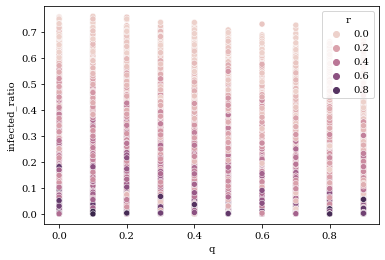

In [207]:
g = sns.scatterplot(
    data = data.sample(frac=1),
    y = 'infected_ratio',
    x = 'q',
    hue = 'r'
)

[Text(0.5, 1.0, 'Infected ratio with variable tracing'),
 Text(0.5, 16.0, 'q'),
 Text(33.99999999999999, 0.5, 'r')]

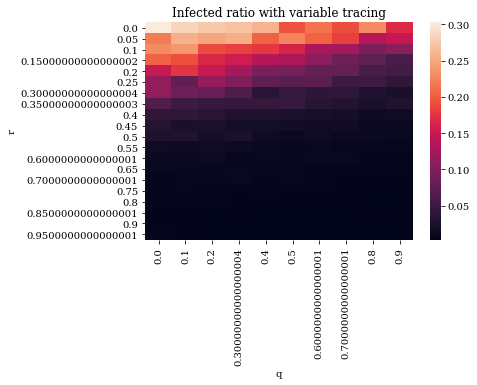

In [208]:
base = 0.05

g, xyz, db = model.binned_heatmap(
    data,
    x = 'q',
    x_base = base * 2,
    y = 'r',
    y_base = base,
    z = 'infected_ratio'
)

g.set(#xscale="log",
      title='Infected ratio with variable tracing',
      xlabel='q',
      ylabel='r')

In [209]:
data[['q','r','upper_mode']]

data.groupby(['q','r'])['upper_mode'].sum()

q    r   
0.0  0.00    95
     0.05    70
     0.10    78
     0.15    74
     0.20    60
             ..
0.9  0.75     0
     0.80     0
     0.85     0
     0.90     0
     0.95     0
Name: upper_mode, Length: 200, dtype: int64

In [210]:
qrdata.loc[0,0]

mean                     0.302751
std                      0.320363
var                      0.102632
count                  200.000000
upper_count              0.000000
upper_mean                    NaN
lower_mean                    NaN
weighted_upper_mean           NaN
Name: (0.0, 0.0), dtype: float64

In [211]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'time', 'A', 'W', 'C', 'beta_hat',
       'alpha', 'gamma', 'zeta', 'limit', 'q', 'r', 'N', 'M', 'p', 's_final',
       'route_adjacent_ratio', 'traced_edges', 'traced_edges_distant',
       'group 0 adoption rate', 'group 1 adoption rate',
       'avg. exp. interval - group 0', 'avg. exp. interval - group 1',
       'avg. eff. inf. interval - group 0',
       'avg. eff. inf. interval - group 1', 'case', 'infected_ratio',
       'traced_edges_close', 'traced_edges_ratio', 'traced_edges_close_ratio',
       'traced_edges+', 'traced_edges_distant_ratio+', 'D', 'T', 'nodes',
       'upper_mode', 'gmode', 'gmode_0_mean', 'gmode_1_mean'],
      dtype='object')

In [212]:
from sklearn import mixture

def gauss_split(d):
    iX = d.values.reshape(-1, 1)

    # Fit a Dirichlet process Gaussian mixture using five components
    dpgmm = mixture.GaussianMixture(n_components=2,
                                        covariance_type='full').fit(iX)
    
    print(dpgmm.converged_)

    return dpgmm

models = data.groupby(['q','r'])['infected_ratio'].apply(lambda x : gauss_split(x))

data['gmode'] = data.apply(lambda x: models.loc[x[11], x[12]].predict(np.array(x[28]).reshape(-1, 1))[0], axis=1)
data['gmode_0_mean'] = data.apply(lambda x: models.loc[x[11], x[12]].means_[0][0], axis=1)
data['gmode_1_mean'] = data.apply(lambda x: models.loc[x[11], x[12]].means_[1][0], axis=1)



True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [213]:
# Reverssing these gmodes so that gmode_0_mean is always less than gmode_1_mean
to_switch = (data['gmode_0_mean'] > data['gmode_1_mean'])
data[to_switch][['gmode_0_mean','gmode_1_mean']]

gmode_0_mean  gmode_1_mean
0          0.630870      0.005682
1          0.630870      0.005682
2          0.630870      0.005682
3          0.630870      0.005682
4          0.630870      0.005682
...             ...           ...
39895      0.010643      0.002034
39896      0.010643      0.002034
39897      0.010643      0.002034
39898      0.010643      0.002034
39899      0.010643      0.002034

[8200 rows x 2 columns]

In [214]:
data.loc[to_switch,'gmode'] = 1 - data[to_switch]['gmode']
zero_mean = data[to_switch]['gmode_0_mean'].copy()
data.loc[to_switch,'gmode_0_mean'] = data[to_switch]['gmode_1_mean']
data.loc[to_switch,'gmode_1_mean'] = zero_mean

In [215]:

data[['gmode_0_mean','gmode_1_mean']][1000:1200]

gmode_0_mean  gmode_1_mean
1000      0.002534      0.086829
1001      0.002534      0.086829
1002      0.002534      0.086829
1003      0.002534      0.086829
1004      0.002534      0.086829
...            ...           ...
1195      0.002687      0.048939
1196      0.002687      0.048939
1197      0.002687      0.048939
1198      0.002687      0.048939
1199      0.002687      0.048939

[200 rows x 2 columns]

In [216]:
data[['q','r','gmode']]

q     r  gmode
0      0.0  0.00      0
1      0.0  0.00      0
2      0.0  0.00      0
3      0.0  0.00      0
4      0.0  0.00      0
...    ...   ...    ...
39995  0.9  0.95      1
39996  0.9  0.95      1
39997  0.9  0.95      1
39998  0.9  0.95      1
39999  0.9  0.95      1

[40000 rows x 3 columns]

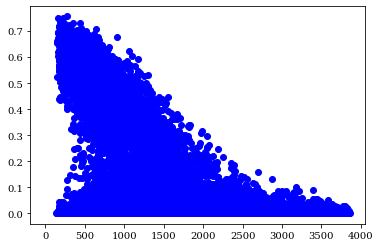

In [217]:

d = data[data['gmode'] == 1]
plt.scatter(d['traced_edges'], d['infected_ratio'], color = 'blue')
    
d = data[~data['gmode'] == 0]
plt.scatter(d['traced_edges'], d['infected_ratio'], color = 'green')

plt.plot(X, Y_pred,linestyle='None',color='red')
#plt.plot(X_upper, Y_upper_pred, color='yellow')
#plt.plot(X_lower, Y_lower_pred, color='cyan')
plt.show()

In [235]:
qrdata = data.groupby(['q','r'])['infected_ratio'].agg(['mean','std','var','count'])
qrdata['upper_count'] = data.groupby(['q','r'])['upper_mode'].sum()
#qrdata['upper_count'] = data.groupby(['q','r'])['upper_mode'].sum()
qrdata['upper_mean'] = data[data['gmode'] == 1].groupby(['q','r'])['infected_ratio'].mean()
qrdata['lower_mean'] = data[~data['gmode'] == 0].groupby(['q','r'])['infected_ratio'].mean()

qrdata['weighted_upper_mean'] = qrdata['upper_mean'] * qrdata['upper_count'] / qrdata['count']

qrdata = qrdata.reset_index()

In [236]:
qrdata

q     r      mean       std       var  count  upper_count  upper_mean  \
0    0.0  0.00  0.302751  0.320363  0.102632    200           95         NaN   
1    0.0  0.05  0.220281  0.296723  0.088044    200           70    0.220281   
2    0.0  0.10  0.231338  0.290303  0.084276    200           78    0.231338   
3    0.0  0.15  0.203526  0.269965  0.072881    200           74    0.203526   
4    0.0  0.20  0.150052  0.230401  0.053085    200           60    0.150052   
..   ...   ...       ...       ...       ...    ...          ...         ...   
195  0.9  0.75  0.004005  0.006486  0.000042    200            0    0.004005   
196  0.9  0.80  0.003923  0.005361  0.000029    200            0    0.003923   
197  0.9  0.85  0.004499  0.006873  0.000047    200            0    0.004499   
198  0.9  0.90  0.003230  0.004302  0.000019    200            0    0.003230   
199  0.9  0.95  0.003296  0.003662  0.000013    200            0    0.003296   

     lower_mean  weighted_upper_mean  
0           NaN                  NaN  
1           NaN             0.077099  
2           NaN             0.090222  
3           NaN             0.075305  
4           NaN             0.045016  
..          ...                  ...  
195         NaN             0.000000  
196         NaN             0.000000  
197         NaN             0.000000  
198         NaN             0.000000  
199         NaN             0.000000  

[200 rows x 10 columns]

<AxesSubplot:xlabel='r', ylabel='upper_mean'>

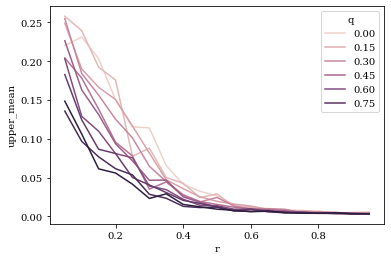

In [237]:
sns.lineplot(
    data=qrdata,
    x = 'r',
    y = 'upper_mean',
    hue = 'q'
)

<AxesSubplot:xlabel='r', ylabel='upper_count'>

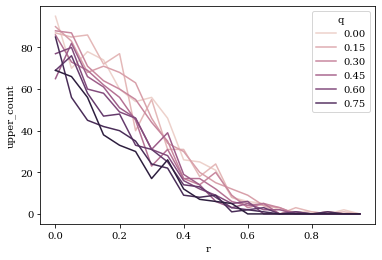

In [238]:
sns.lineplot(
    data=qrdata,
    x = 'r',
    y = 'upper_count',
    hue = 'q'
)

<AxesSubplot:xlabel='r', ylabel='weighted_upper_mean'>

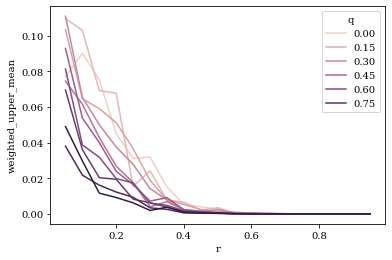

In [239]:
sns.lineplot(
    data=qrdata,
    x = 'r',
    y = 'weighted_upper_mean',
    hue = 'q'
)

In [240]:
delta_q_diff_mean = qrdata.pivot('q','r','mean').diff()
delta_q_pooled_s = ((qrdata.pivot('q','r','var') + qrdata.pivot('q','r','var').shift(1)) /2).apply(np.sqrt)

delta_q_cohen_d = delta_q_diff_mean / delta_q_pooled_s

qrdata['delta_q_d'] = delta_q_cohen_d.fillna(0).reset_index().melt(
    id_vars=['q']
).sort_values(['q','r'], ignore_index=True)['value']

In [241]:
delta_q_cohen_d.fillna(0).reset_index().melt(
    id_vars=['q']
).sort_values(['q','r'], ignore_index=True)

q     r     value
0    0.0     0  0.000000
1    0.0  0.05  0.000000
2    0.0   0.1  0.000000
3    0.0  0.15  0.000000
4    0.0   0.2  0.000000
..   ...   ...       ...
195  0.9  0.75  0.002982
196  0.9   0.8 -0.007746
197  0.9  0.85 -0.033909
198  0.9   0.9 -0.054051
199  0.9  0.95 -0.001334

[200 rows x 3 columns]

In [242]:
delta_r_diff_mean = qrdata.pivot('q','r','mean').diff(axis=1)
delta_r_pooled_s = ((qrdata.pivot('q','r','var') + qrdata.pivot('q','r','var').shift(1, axis=1)) /2).apply(np.sqrt)

delta_r_cohen_d = delta_r_diff_mean / delta_r_pooled_s

qrdata['delta_r_d'] = delta_r_cohen_d.fillna(0).reset_index().melt(
    id_vars=['q']).sort_values(
    ['q','r'], ignore_index=True
)['value']

<AxesSubplot:xlabel='r', ylabel='q'>

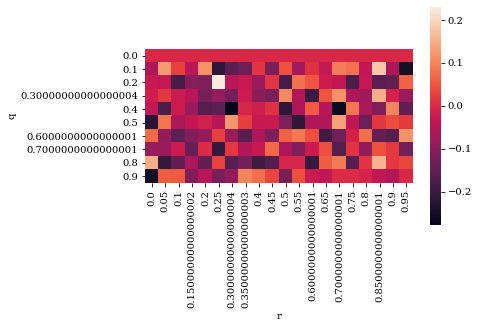

In [243]:
sns.heatmap(qrdata.pivot('q','r','delta_q_d'), square = True)

<AxesSubplot:xlabel='r', ylabel='q'>

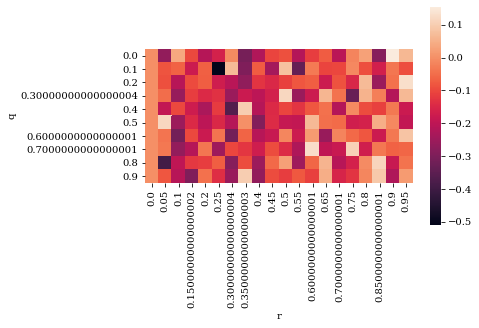

In [244]:
sns.heatmap(qrdata.pivot('q','r','delta_r_d'), square = True)

<AxesSubplot:xlabel='r', ylabel='q'>

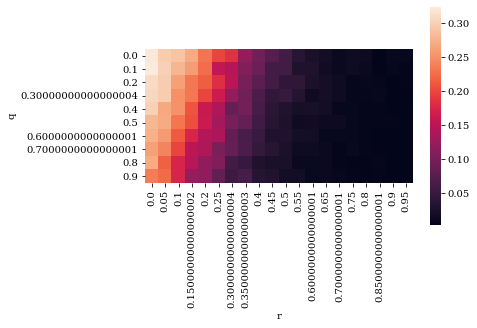

In [245]:
sns.heatmap(qrdata.pivot('q','r','std'),square=True)

<AxesSubplot:xlabel='r', ylabel='q'>

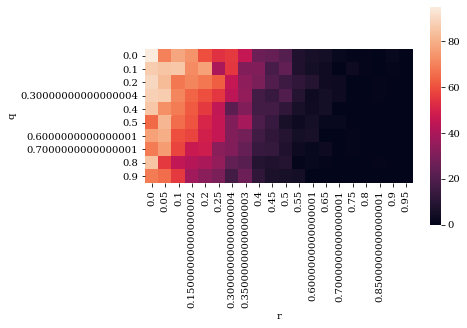

In [246]:
sns.heatmap(qrdata.pivot('q','r','upper_count'),square=True)

<AxesSubplot:xlabel='r', ylabel='q'>

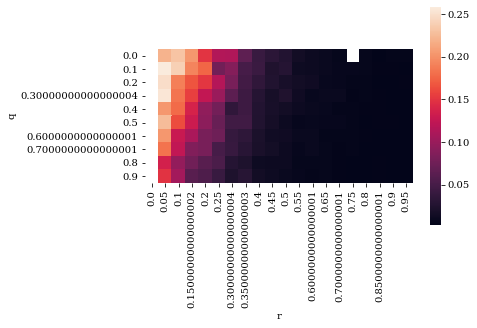

In [247]:
sns.heatmap(qrdata.pivot('q','r','upper_mean'),square=True)

<AxesSubplot:xlabel='r', ylabel='q'>

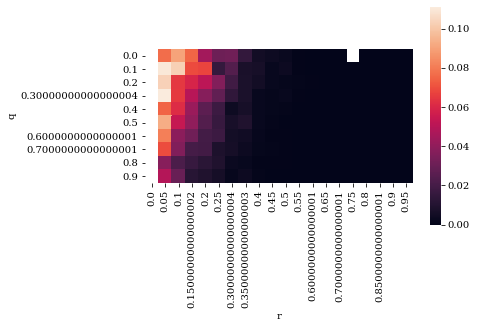

In [248]:
sns.heatmap(qrdata.pivot('q','r','weighted_upper_mean'),square=True)

<AxesSubplot:xlabel='r', ylabel='q'>

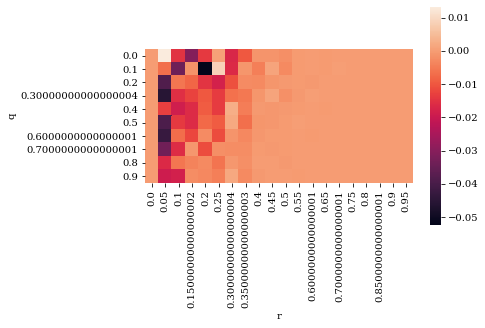

In [249]:
delta_r_diff_wum = qrdata.pivot('q','r','weighted_upper_mean').diff(axis=1).shift(-1, axis=1)

qrdata['delta_r_wum'] = delta_r_diff_wum.fillna(0).reset_index().melt(
    id_vars=['q']).sort_values(
    ['q','r'], ignore_index=True
)['value']

sns.heatmap(qrdata.pivot('q','r','delta_r_wum'),square=True)

<AxesSubplot:xlabel='r', ylabel='q'>

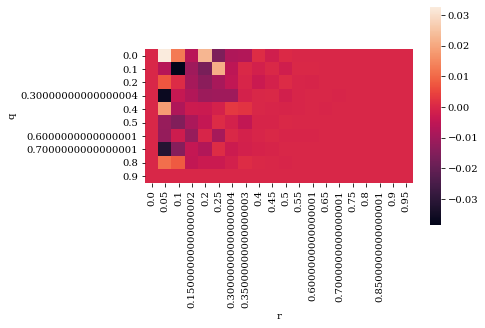

In [250]:
delta_q_diff_wum = qrdata.pivot('q','r','weighted_upper_mean').diff(axis=0).shift(-1, axis=0)

qrdata['delta_q_wum'] = delta_q_diff_wum.fillna(0).reset_index().melt(
    id_vars=['q']).sort_values(
    ['q','r'], ignore_index=True
)['value']

sns.heatmap(qrdata.pivot('q','r','delta_q_wum'),square=True)

This is a ratio of the differences $\frac{\Delta_r \bar{i}}{\Delta_q \bar{i}}$

<AxesSubplot:xlabel='r', ylabel='q'>

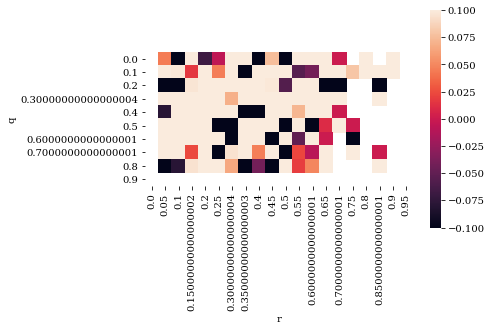

In [259]:
p = 0.1

## getting relative difference in mean, weighted by number of edges associated with the change.

diff = (qrdata.pivot('q','r','delta_r_wum') / (1 - p)) / (qrdata.pivot('q','r','delta_q_wum') / (p))



sns.heatmap(diff,square=True)

In [258]:
diff.mean()

r
0.00         NaN
0.05        -inf
0.10        -inf
0.15        -inf
0.20        -inf
0.25        -inf
0.30         inf
0.35        -inf
0.40        -inf
0.45        -inf
0.50        -inf
0.55        -inf
0.60    0.066022
0.65    0.401994
0.70         inf
0.75   -1.090521
0.80         inf
0.85         inf
0.90    0.155283
0.95         NaN
dtype: float64

In [253]:
diff.sum(axis=1)

q
0.0   -0.396784
0.1    0.453285
0.2    0.203711
0.3    0.690492
0.4   -0.164312
0.5    0.338871
0.6    0.275779
0.7    0.541447
0.8   -0.124045
0.9   -0.054479
dtype: float64